# Проект создания модели BERT по поиску токсичных комментариев для Интернет-магазин «Викишоп»

## Цели исследования

- Разработать модель на основе BERT для поиска токсичных комментариев и последующей модерации.

- Оценка качества модели.

## Ход исследования

- Загрузка и ознакомление с данными.


- Подготовка текстовых данных.


- Обучение модели и оценка эффективности.


- Финальный вывод и рекомендации на основании полученных результатов.


## Техническая секция

### Импорты библиотек

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import warnings
import time
import matplotlib.ticker as ticker
import torch
import transformers
import pickle
import joblib
import re
import tqdm
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer 
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import FunctionTransformer
from tqdm import notebook
from sklearn.model_selection import cross_validate
from lightgbm import LGBMClassifier
from ydata_profiling import ProfileReport
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

### Определение констант

In [2]:
RS = 42
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=UserWarning)


### Кастомные функции

In [3]:
def df_info(df, name="df"):
    """
    Выводит информацию о DataFrame: info(), describe() и первые 10 строк
    
    Parameters:
    df (pd.DataFrame): DataFrame для анализа
    name (str): имя DataFrame для отображения (по умолчанию "df")
    """
    print(f"=== ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ '{name}' ===")
    print(f"Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")
    print()
    
    print("1. ИНФОРМАЦИЯ О ДАННЫХ (info()):")
    display(df.info())
    print()
    
    print("2. СТАТИСТИЧЕСКОЕ ОПИСАНИЕ (describe().T):")
    display(df.describe().T)
    print()
    
    print("3. ПЕРВЫЕ 10 СТРОК:")
    display(df.head(10))
    print("="*60)

In [4]:
def check_data_dubmiss(df, df_name='DataFrame'):
    """
    Анализирует DataFrame на дубликаты и пропущенные значения.
    Возвращает единый отчет в виде DataFrame с категориями.

    Параметры:
    - df: pandas DataFrame для проверки
    - df_name: название DataFrame для отчета

    Возвращает:
    - Единый DataFrame с отчетом
    """
    report_parts = []

    # 1. Общая информация
    info_df = pd.DataFrame({
        'Категория': ['Общая информация'],
        'Параметр': ['Название датафрейма'],
        'Значение': [df_name],
        'Детали': [f'Размер : {df.shape[0]} x {df.shape[1]}']
    })
    report_parts.append(info_df)

    # 2. Дубликаты
    duplicates = df.duplicated().sum()
    duplicates_df = pd.DataFrame({
        'Категория': ['Дубликаты', 'Дубликаты'],
        'Параметр': ['Всего дубликатов', 'Примеры дубликатов'],
        'Значение': [duplicates, duplicates > 0],
        'Детали': ['', f"Первые {min(5, duplicates)} примеров" if duplicates > 0 else '']
    })
    report_parts.append(duplicates_df)

    # 3. Пропущенные значения по столбцам
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    if missing.sum() > 0:
        missing_df = pd.DataFrame({
            'Категория': ['Пропущенные значения'] * len(missing),
            'Параметр': missing.index,
            'Значение': missing.values,
            'Детали': [f"{pct:.2f}%" for pct in missing_pct.values]
        })
        missing_df = missing_df[missing_df['Значение'] > 0]
        report_parts.append(missing_df)

    # 4. Итог по пропущенным значениям
    total_missing_df = pd.DataFrame({
        'Категория': ['Пропуски'],
        'Параметр': ['Всего пропущенных значений'],
        'Значение': [missing.sum()],
        'Детали': [f"{missing.sum() / df.size:.2%} от всех ячеек"]
    })
    report_parts.append(total_missing_df)

    report = pd.concat(report_parts, ignore_index=True)

    if duplicates > 0:
        duplicates_examples = df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist()).head()
        report.at[4, 'Детали'] = str(duplicates_examples.to_dict('records'))

    return report

## Загрузка и первичное ознакомление с  данными

In [5]:
try:
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

In [6]:
df_info(df, 'toxic_comments.csv')

=== ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ 'toxic_comments.csv' ===
Размер: 159292 строк, 3 столбцов

1. ИНФОРМАЦИЯ О ДАННЫХ (info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None


2. СТАТИСТИЧЕСКОЕ ОПИСАНИЕ (describe().T):


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,159292.0,79725.697242,46028.837471,0.0,39872.75,79721.5,119573.25,159450.0
toxic,159292.0,0.101612,0.302139,0.0,0.00,0.0,0.00,1.0



3. ПЕРВЫЕ 10 СТРОК:


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [7]:
check_data_dubmiss(df, 'toxic_comments.csv')

,Категория,Параметр,Значение,Детали
0,Общая информация,Название датафрейма,toxic_comments.csv,Размер : 159292 x 3
1,Дубликаты,Всего дубликатов,0,
2,Дубликаты,Примеры дубликатов,False,
3,Пропуски,Всего пропущенных значений,0,0.00% от всех ячеек


In [8]:
ProfileReport(df, title="Profiling Report", minimal=False, progress_bar=False)

100%|██████████| 3/3 [00:08<00:00,  2.93s/it]


### Вывод

- Мы загрузили присланный нам заказчиком датасет , пропусков и дубликатов обнаружено не было как и видимых дефектов.

## Подготовка данных

Для улучшение качества и скорости работы моделей , проведем базовую очистку текстов удалив такие артефакты выгрузки как ip-адреса , время сообщения и веб-ссылки.

In [9]:
def preprocess_text(text):
    """
    Базовая очистка текста перед подачей в модель со знаками препинания
    """
    if not isinstance(text, str):
        return ""
    
    # Удаление IP-адресов
    text = re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', '', text)
    
    # Удаление времени (форматы: 12:30, 12:30:45, 12.30, 12.30.45)
    text = re.sub(r'\b\d{1,2}[:\.]\d{1,2}(?:[:\.]\d{1,2})?\b', '', text)
    
    # Удаление UTC времени (форматы: 12:30 UTC, 12:30:45 UTC, 12:30 GMT, 12:30+00:00)
    text = re.sub(r'\b\d{1,2}[:\.]\d{1,2}(?:[:\.]\d{1,2})?\s*(?:UTC|GMT)?\s*(?:[\+\-]\d{1,2}[:\.]?\d{2})?\b', '', text)
    
    # Удаление ссылок (http, https, www)
    text = re.sub(r'https?:\/\/[^\s]+', '', text)  # http/https ссылки
    text = re.sub(r'www\.[^\s]+', '', text)        # www ссылки
    text = re.sub(r'[a-zA-Z0-9]+\.[a-zA-Z]{2,}(?:\/[^\s]*)?', '', text)  # домены без www
    
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)
    # Оставим пока знаки препинания так как bert модель умеет с ними работать.    
    return text.strip()

In [10]:
texts = df['text'].apply(preprocess_text)
texts.head(10)

0    Explanation Why the edits made under my userna...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    " More I can't make any real suggestions on im...
4    You, sir, are my hero. Any chance you remember...
5    " Congratulations from me as well, use the too...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: text, dtype: object

### Токенизация BERT base

Загрузка обученного на английских текстах *токенайзера*

In [12]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

Некоторые твиты достаточно длинные для BERT модели , ограничим их тонизацию вручную.

Так же выполним *падинг* и *маску внимания* при помощи встроенного в токенизатор метода.

In [18]:
# Переведем в лист , перегонка в тензоры должна быть быстрее
tokenized = df['text'].apply(
    lambda x: tokenizer.encode_plus(
        x,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
).to_list()

In [21]:
input_ids = [item['input_ids'] for item in tokenized]
attention_masks = [item['attention_mask'] for item in tokenized]

In [22]:
model = transformers.BertModel.from_pretrained('bert-base-cased')

In [ ]:
dataset = TensorDataset(
    torch.LongTensor(input_ids), 
    torch.LongTensor(attention_masks)
)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Перенос модели на GPU 
device = torch.device('cuda')
model = model.to(device)
model.eval()

embeddings_raw = []
with torch.no_grad():
    for batch, attention_mask_batch in notebook.tqdm(dataloader):
        batch = batch.to(device)
        attention_mask_batch = attention_mask_batch.to(device)
        
        outputs = model(batch, attention_mask=attention_mask_batch)
        
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings_raw.append(cls_embeddings)



  0%|          | 0/2489 [00:00<?, ?it/s]

Загрузим ранее сохраненные результаты.

In [11]:
embeddings_raw = joblib.load('embeddings_raw.pkl')

In [12]:
features_base = np.vstack(embeddings_raw)
print(f"Форма финальных эмбеддингов: {features_base.shape}")

Форма финальных эмбеддингов: (159292, 768)


### Вывод

- Мы провели базовую обработку всего текста убрав артефакты в виде времени выгрузки и ip-адреса , что должно положительно сказаться на работе моделей.

- Так же получили эмбидинги для всего корпуса текстов при помощи уже обученной модели семейства BERT.

## Перебор моделей

### С BERT эмбедингом 

In [13]:
X = features_base
y = df['toxic']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RS) 

In [16]:
models = {
    'CatBoost': {
        'model': CatBoostClassifier(random_state=RS, verbose=False),
        'params': {
            'regressor__iterations': [50, 100],
            'regressor__learning_rate': [0.05, 0.1],
            'regressor__depth': [4, 6]
        }
    },
    
    'LightGBM': {
        'model': LGBMClassifier(random_state=RS, verbose=-1),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.05, 0.1],
            'regressor__max_depth': [5, -1]
        }
    },
    
    'LogisticRegression': {
        'model': LogisticRegression(random_state=RS, max_iter=1000),
        'params': {
            'regressor__C': [0.1, 1.0, 10.0],
            'regressor__solver': ['liblinear']
        }
    },
    
    'LinearSVC': {
        'model': LinearSVC(random_state=RS, max_iter=1000),
        'params': {
            'regressor__C': [0.1, 1.0],
            'regressor__loss': ['squared_hinge']
        }
    }
}

In [17]:
%%time
results = {}

for name, config in models.items():
    
    pipeline = Pipeline([
        ('preprocessor', None),
        ('regressor', config['model'])
    ])
    
    grid = GridSearchCV(
        pipeline,
        config['params'],
        scoring='f1',  
        refit=True,    
        cv=3,       # Уменьшил для скорости
        n_jobs=6,  # Поставь свое значение , у меня на -1 было переполнение памяти и все крашилось , у меня переодически фейлятся некоторые фиты catboosta
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    results[name] = {
        'best_model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_f1_score': grid.best_score_,
        'mean_fit_time': grid.cv_results_['mean_fit_time'].mean(), 
        'mean_score_time': grid.cv_results_['mean_score_time'].mean(),
        'full_cv_results': grid.cv_results_
    }
    
    print(f"{name} completed.")
    print(f"Best F1: {results[name]['best_f1_score']:.4f}")
    print("-" * 50)

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

for name, res in results.items():
    print(f"\n{name}:")
    print(f"Best F1: {res['best_f1_score']:.4f}")
    print(f"Mean Fit Time: {res['mean_fit_time']:.2f}s")
    print(f"Mean Score Time: {res['mean_score_time']:.2f}s")
    print(f"Best Params: {res['best_params']}")
    print("-" * 80)

# Создаем DataFrame для удобного сравнения моделей
results_df_bert = pd.DataFrame({
    'Model': list(results.keys()),
    'F1_Score': [res['best_f1_score'] for res in results.values()],
    'Fit_Time': [res['mean_fit_time'] for res in results.values()],
    'Score_Time': [res['mean_score_time'] for res in results.values()]
})

print("\n" + "="*80)
print("COMPARISON TABLE (sorted by F1 Score)")
print("="*80)
print(results_df_bert.sort_values('F1_Score', ascending=False).round(4))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
CatBoost completed.
Best F1: 0.6131
--------------------------------------------------
Fitting 3 folds for each of 8 candidates, totalling 24 fits
LightGBM completed.
Best F1: 0.6541
--------------------------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
LogisticRegression completed.
Best F1: 0.7054
--------------------------------------------------
Fitting 3 folds for each of 2 candidates, totalling 6 fits
LinearSVC completed.
Best F1: 0.7001
--------------------------------------------------

FINAL RESULTS SUMMARY

CatBoost:
Best F1: 0.6131
Mean Fit Time: 20.86s
Mean Score Time: 0.18s
Best Params: {'regressor__depth': 6, 'regressor__iterations': 100, 'regressor__learning_rate': 0.1}
--------------------------------------------------------------------------------

LightGBM:
Best F1: 0.6541
Mean Fit Time: 42.35s
Mean Score Time: 0.10s
Best Params: {'regressor__learning_rate': 0.1, 'regress

In [18]:
results_df_bert.sort_values('F1_Score', ascending=False)

,Model,F1_Score,Fit_Time,Score_Time
2,LogisticRegression,0.705407,36.419418,0.107891
3,LinearSVC,0.700050,21.280451,0.092872
1,LightGBM,0.654066,42.347474,0.103134
0,CatBoost,0.613142,20.855809,0.176883


Видим что ни одной модели не удалось достичь значения метрики в 0.75 которая была установленна заказчиком.

Лучшей среди всех с небольшим отрывом оказалась LogisticRegression , ей и воспользуемся для проверки на тестовых данных.

<span style="font-size: 30px">Проверка модели на тестовых данных</span>


Передадим лучшей модели тестовую выборку.

In [19]:
model_bert = results['LogisticRegression']['best_model']

In [20]:
y_pred_bert = model_bert.predict(X_test)

In [21]:
print(f'Результат метрики f1 на тестовой выборке при использовании метода модели BERT : {f1_score(y_test, y_pred_bert):.2f}') 

Результат метрики f1 на тестовой выборке при использовании метода модели BERT : 0.71


Результат не сильно отличается от работы модели на тренировочных данных.

Используем другие подходы , что бы удовлетворить требования заказчика.

### С Лемматизацией

Для получения лемм слов будем использовать уже готовый вариант реализованный в библиотеке spacy.

In [12]:
spacy.prefer_gpu()  # так получилось на 10минут быстрее чем на cpu

def lemmatize_batch_en(texts, batch=64, model_name="en_core_web_sm"):
    """Пакетная обработка английских текстов на GPU"""
    
    # Загрузка английской модели
    nlp = spacy.load(model_name)
    
    lemmatized_texts = []
    
    for doc in tqdm(nlp.pipe(texts, batch_size=batch, n_process=4), 
                    total=len(texts),
                    desc="Lemmatization EN"):
        lemmas = [
            token.lemma_.lower() 
            for token in doc 
            if not token.is_stop 
            and not token.is_punct 
            and not token.is_space
        ]
        lemmatized_texts.append(' '.join(lemmas))
    
    return lemmatized_texts

In [13]:
lemmas = lemmatize_batch_en(texts, batch=64)

Lemmatization EN:   0%|          | 0/159292 [00:00<?, ?it/s]C:\Users\para\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\spacy\language.py:1612: UserWarning: [W114] Using multiprocessing with GPU models is not recommended and may lead to errors.
  warnings.warn(Warnings.W114)
Lemmatization EN: 100%|██████████| 159292/159292 [10:01<00:00, 264.69it/s]


In [28]:
result_series = pd.Series(lemmas, index=texts.index)

Сохраним результаты что бы каждый раз не выполнять долгую обработку.

In [25]:
result_series.to_csv('lemmas.csv', index=False)

Загрузим результат обработки полученный ранее.

In [ ]:
# result_series = pd.read_csv('lemmas.csv')

Теперь проведем аналогичное обучение моделей но уже на структуре tf-idf

In [36]:
X = result_series
y = df['toxic']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RS) 

In [38]:
models = {
    'CatBoost': {
        'model': CatBoostClassifier(random_state=RS, verbose=False),
        'params': {
             'regressor__iterations': [50, 100],
            'regressor__learning_rate': [0.05, 0.1],
            'regressor__depth': [4, 6]
        }
    },
    
    'LightGBM': {
        'model': LGBMClassifier(random_state=RS, verbose=-1),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.05, 0.1],
            'regressor__max_depth': [5, -1]
        }
    },
    
    'LogisticRegression': {
        'model': LogisticRegression(random_state=RS, max_iter=1000),
        'params': {
            'regressor__C': [0.1, 1.0, 10.0],
            'regressor__solver': ['liblinear']
        }
    },
    
    'LinearSVC': {
        'model': LinearSVC(random_state=RS, max_iter=1000),
        'params': {
            'regressor__C': [0.1, 1.0],
            'regressor__loss': ['squared_hinge']
        }
    }
}

In [39]:
%%time
results = {}

for name, config in models.items():
    
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('regressor', config['model'])
    ])
        
    grid = GridSearchCV(
        pipeline,
        config['params'],
        scoring='f1',  
        refit=True,    
        cv=3,       # Уменьшил для скорости
        n_jobs=6,  # Поставь свое значение , у меня на -1 было переполнение памяти и все крашилось иногда некоторые фиты всеравно фейлятся
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    results[name] = {
        'best_model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_f1_score': grid.best_score_,
        'mean_fit_time': grid.cv_results_['mean_fit_time'].mean(), 
        'mean_score_time': grid.cv_results_['mean_score_time'].mean(),
        'full_cv_results': grid.cv_results_
    }
    
    print(f"{name} completed.")
    print(f"Best F1: {results[name]['best_f1_score']:.4f}")
    print("-" * 50)

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

for name, res in results.items():
    print(f"\n{name}:")
    print(f"Best F1: {res['best_f1_score']:.4f}")
    print(f"Mean Fit Time: {res['mean_fit_time']:.2f}s")
    print(f"Mean Score Time: {res['mean_score_time']:.2f}s")
    print(f"Best Params: {res['best_params']}")
    print("-" * 80)

# Создаем DataFrame для удобного сравнения моделей
results_df_lemm = pd.DataFrame({
    'Model': list(results.keys()),
    'F1_Score': [res['best_f1_score'] for res in results.values()],
    'Fit_Time': [res['mean_fit_time'] for res in results.values()],
    'Score_Time': [res['mean_score_time'] for res in results.values()]
})

print("\n" + "="*80)
print("COMPARISON TABLE (sorted by F1 Score)")
print("="*80)
print(results_df_lemm.sort_values('F1_Score', ascending=False).round(4))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\para\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\para\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\para\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\

CatBoost completed.
Best F1: 0.6270
--------------------------------------------------
Fitting 3 folds for each of 8 candidates, totalling 24 fits
LightGBM completed.
Best F1: 0.7647
--------------------------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
LogisticRegression completed.
Best F1: 0.7708
--------------------------------------------------
Fitting 3 folds for each of 2 candidates, totalling 6 fits
LinearSVC completed.
Best F1: 0.7759
--------------------------------------------------

FINAL RESULTS SUMMARY

CatBoost:
Best F1: 0.6270
Mean Fit Time: 63.84s
Mean Score Time: 1.89s
Best Params: {'regressor__depth': 4, 'regressor__iterations': 100, 'regressor__learning_rate': 0.1}
--------------------------------------------------------------------------------

LightGBM:
Best F1: 0.7647
Mean Fit Time: 26.47s
Mean Score Time: 2.15s
Best Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': -1, 'regressor__n_estimators': 200}
--------

In [40]:
results_df_lemm.sort_values('F1_Score', ascending=False)

,Model,F1_Score,Fit_Time,Score_Time
3,LinearSVC,0.775888,2.166861,0.815210
2,LogisticRegression,0.770843,2.826811,0.966953
1,LightGBM,0.764716,26.465426,2.150831
0,CatBoost,0.626999,63.838026,1.889065


В целом все модели показали близкие друг другу результаты , но LinearSVC показал себя немного лучше его и будем использовать в дальнейшем.

<span style="font-size: 30px">Проверка модели на тестовых данных</span>


Передадим лучшей модели тестовую выборку.

In [42]:
model_lemm = results['LinearSVC']['best_model']

In [47]:
y_pred_lemm = model_lemm.predict(X_test)

In [48]:
print(f'Результат метрики f1 на тестовой выборке при использовании метода с лемматизацией : {f1_score(y_test, y_pred_lemm):.2f}') 

Результат метрики f1 на тестовой выборке при использовании метода с лемматизацией : 0.78


Видим что методом лемматизации и преобразованием TF-IDF удалось достичь установленного порога качества.

Посмотрим удастся ли улучшить этот результат.

#### Вывод топа значимости слов для кларификации моделью.

In [58]:
tfidf = model_lemm.named_steps['tfidf']
svc = model_lemm.named_steps['regressor']

feature_names = tfidf.get_feature_names_out()
coefficients = svc.coef_[0]  

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': coefficients
})

top_words = feature_importance.sort_values('importance', ascending=False)

print("Топ-20 самых важных слов:")
display(top_words.head(20))

Топ-20 самых важных слов:


,feature,importance
50090,fuck,9.877827
50121,fucking,7.093815
113056,shit,6.108566
60989,idiot,5.546830
18871,bitch,5.506765
13289,asshole,5.257394
22112,bullshit,5.186616
13200,ass,5.182138
119853,suck,4.890792
45983,faggot,4.788009


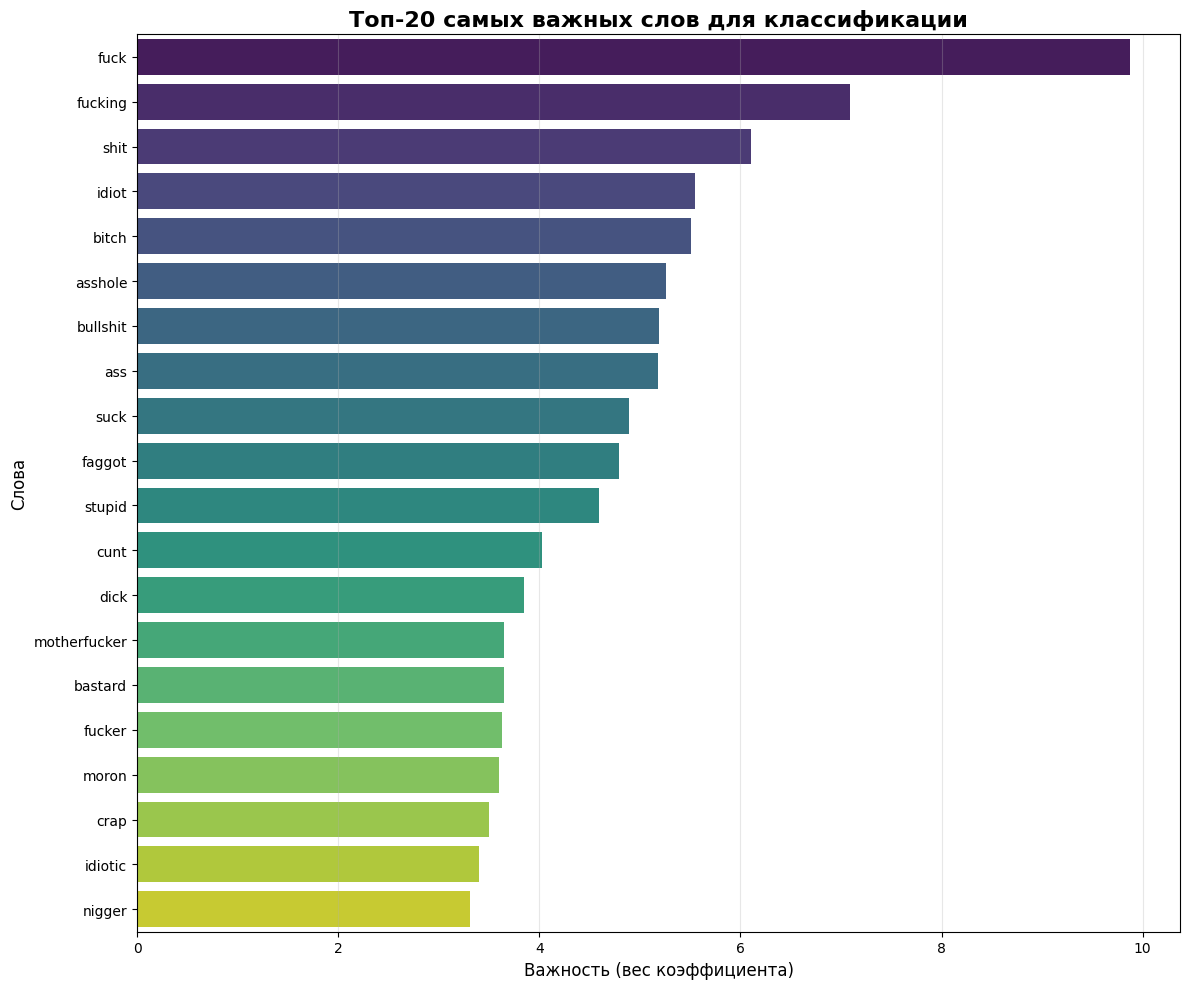

In [59]:
top_20 = top_words.head(20)

plt.figure(figsize=(12, 10))
sns.barplot(data=top_20, y='feature', x='importance', palette='viridis')
plt.title('Топ-20 самых важных слов для классификации', fontsize=16, fontweight='bold')
plt.xlabel('Важность (вес коэффициента)', fontsize=12)
plt.ylabel('Слова', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Видим что модель в целом правильно определила слова по которым легко можно установить токсичность оставленного комментария.

### Токенизация и предсказания модели Roberta(toxic)

Воспользуемся моделью с *предсказательной головой* , полученные результаты в дальнейшем сравним с нашим стандартным подходом с *классическими моделями*

In [67]:
texts_list = texts.to_list()

In [68]:
model_name = "unitary/toxic-bert"
tokenizer_rob = AutoTokenizer.from_pretrained(model_name)
model_rob = AutoModelForSequenceClassification.from_pretrained(model_name)

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rob.to(device)
model_rob.eval();

In [ ]:
def get_binary_predictions(texts, batch_size=16, threshold=0.5):
    all_embeddings = []
    all_binary_predictions = []
    all_probabilities = []
    
    for i in notebook.tqdm(range(0, len(texts), batch_size), desc="Processing"):
        batch_texts = texts[i:i+batch_size]
        
        inputs = tokenizer_rob(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        ).to(device)
        
        with torch.no_grad():
            outputs = model_rob(**inputs, output_hidden_states=True)
            
            probabilities = torch.sigmoid(outputs.logits)
            
            # Бинарная классификация: токсичен если любой класс > threshold
            binary_predictions = (probabilities.max(dim=1).values > threshold).float()
            
            last_hidden_state = outputs.hidden_states[-1]
            cls_embeddings = last_hidden_state[:, 0, :]
            
        all_embeddings.append(cls_embeddings.cpu().numpy())
        all_binary_predictions.extend(binary_predictions.cpu().numpy())
        all_probabilities.append(probabilities.cpu().numpy())
    
    embeddings_array = np.vstack(all_embeddings)
    binary_predictions_array = np.array(all_binary_predictions)
    probabilities_array = np.vstack(all_probabilities)
    
    return embeddings_array, binary_predictions_array, probabilities_array

# Использование
embeddings_new, binary_preds_new, probs_new = get_binary_predictions(texts_list, batch_size=64)
# print(f"Токсичных текстов: {binary_preds.sum()} из {len(binary_preds)}")

Processing:   0%|          | 0/2489 [00:00<?, ?it/s]

Загрузим ранее сохраненные результаты работы модели.

In [39]:
embeddings_new = np.load('toxic_emb.npy')

In [40]:
binary_preds_new = np.load('predict.npy')

In [41]:
probs_new = np.load('proba.npy')

Проверим работу *классических* выбранных нами моделей и сравним с результатом предсказания RoBERTa

In [42]:
X = embeddings_new
y = df['toxic']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RS) 

In [44]:
models = {
    'CatBoost': {
        'model': CatBoostClassifier(random_state=RS, verbose=False),
        'params': {
            'regressor__iterations': [100, 200],
            'regressor__learning_rate': [0.05, 0.1],
            'regressor__depth': [6, 8]
        }
    },
    
    'LightGBM': {
        'model': LGBMClassifier(random_state=RS),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.05, 0.1],
            'regressor__max_depth': [5, -1]
        }
    },
    
    'LogisticRegression': {
        'model': LogisticRegression(random_state=RS, max_iter=1000),
        'params': {
            'regressor__C': [0.1, 1.0, 10.0],
            'regressor__solver': ['liblinear']
        }
    },
    
    'LinearSVC': {
        'model': LinearSVC(random_state=RS, max_iter=1000),
        'params': {
            'regressor__C': [0.1, 1.0],
            'regressor__loss': ['squared_hinge']
        }
    }
}

In [45]:
%%time
results = {}

for name, config in models.items():
    
    pipeline = Pipeline([
        ('preprocessor', None),
        ('regressor', config['model'])
    ])
    
    grid = GridSearchCV(
        pipeline,
        config['params'],
        scoring='f1',  
        refit=True,    
        cv=3,       # Уменьшил для скорости
        n_jobs=10,  # Поставь свое значение , у меня на -1 было переполнение памяти и все крашилось
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    results[name] = {
        'best_model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_f1_score': grid.best_score_,
        'mean_fit_time': grid.cv_results_['mean_fit_time'].mean(), 
        'mean_score_time': grid.cv_results_['mean_score_time'].mean(),
        'full_cv_results': grid.cv_results_
    }
    
    print(f"{name} completed.")
    print(f"Best F1: {results[name]['best_f1_score']:.4f}")
    print("-" * 50)

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

for name, res in results.items():
    print(f"\n{name}:")
    print(f"Best F1: {res['best_f1_score']:.4f}")
    print(f"Mean Fit Time: {res['mean_fit_time']:.2f}s")
    print(f"Mean Score Time: {res['mean_score_time']:.2f}s")
    print(f"Best Params: {res['best_params']}")
    print("-" * 80)

# Создаем DataFrame для удобного сравнения моделей
results_df_tox = pd.DataFrame({
    'Model': list(results.keys()),
    'F1_Score': [res['best_f1_score'] for res in results.values()],
    'Fit_Time': [res['mean_fit_time'] for res in results.values()],
    'Score_Time': [res['mean_score_time'] for res in results.values()]
})

print("\n" + "="*80)
print("COMPARISON TABLE (sorted by F1 Score)")
print("="*80)
print(results_df_tox.sort_values('F1_Score', ascending=False).round(4))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\para\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\para\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\para\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\

CatBoost completed.
Best F1: 0.9441
--------------------------------------------------
Fitting 3 folds for each of 8 candidates, totalling 24 fits
LightGBM completed.
Best F1: 0.9440
--------------------------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
LogisticRegression completed.
Best F1: 0.9456
--------------------------------------------------
Fitting 3 folds for each of 2 candidates, totalling 6 fits
LinearSVC completed.
Best F1: 0.9442
--------------------------------------------------

FINAL RESULTS SUMMARY

CatBoost:
Best F1: 0.9441
Mean Fit Time: 63.46s
Mean Score Time: 0.37s
Best Params: {'regressor__depth': 6, 'regressor__iterations': 100, 'regressor__learning_rate': 0.1}
--------------------------------------------------------------------------------

LightGBM:
Best F1: 0.9440
Mean Fit Time: 52.98s
Mean Score Time: 0.10s
Best Params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
--------

In [46]:
results_df_tox.sort_values('F1_Score', ascending=False)

,Model,F1_Score,Fit_Time,Score_Time
2,LogisticRegression,0.945601,55.643232,0.106266
3,LinearSVC,0.944248,11.203491,0.102442
0,CatBoost,0.944073,63.458923,0.370998
1,LightGBM,0.944043,52.978632,0.095417


Видим что обработка специализированной для выявления токсичности модели , значительно повысила качество предсказания *класических моделей* улучшив метрику f1 до 0.94.

Аналогично предыдущим шагам проверим лучшую модель на тестовых данных.

<span style="font-size: 30px">Проверка модели на тестовых данных</span>


Передадим лучшей модели тестовую выборку.

In [47]:
model_tox = results['LogisticRegression']['best_model']

In [48]:
y_pred_tox = model_tox.predict(X_test)

In [49]:
print(f'Результат метрики f1 на тестовой выборке при использовании метода модели BERT : {f1_score(y_test, y_pred_tox):.2f}') 

Результат метрики f1 на тестовой выборке при использовании метода модели BERT : 0.94


Так же оценим работу встроенного в модель модуля предсказания.

In [56]:
y_test_full = df['toxic'].to_numpy()

In [57]:
print(f'Результат метрики f1 встроенным в модель предсказателем : {f1_score(binary_preds_new, y_test_full):.2f}') 

Результат метрики f1 встроенным в модель предсказателем : 0.94


Как видим разметка текста специально обученной на поиск токсичности модели , показала лучший результат как для *классических* моделей так и встроенным в нее методои.

### Табличное сравнение.

Классические модели с BERT эмбидингом.

In [52]:
results_df_bert.sort_values('F1_Score', ascending=False)

,Model,F1_Score,Fit_Time,Score_Time
2,LogisticRegression,0.705407,36.419418,0.107891
3,LinearSVC,0.700050,21.280451,0.092872
1,LightGBM,0.654066,42.347474,0.103134
0,CatBoost,0.613142,20.855809,0.176883


Подход с лемматизацией и TFIDF.

In [53]:
results_df_lemm.sort_values('F1_Score', ascending=False)

,Model,F1_Score,Fit_Time,Score_Time
3,LinearSVC,0.767502,0.409710,0.009276
2,LogisticRegression,0.761792,0.681951,0.010216
1,LightGBM,0.759874,26.246423,0.679304
0,CatBoost,0.621667,47.883808,0.580043


Работа RoBERTa (toxic)

In [54]:
results_df_tox.sort_values('F1_Score', ascending=False)

,Model,F1_Score,Fit_Time,Score_Time
2,LogisticRegression,0.945601,55.643232,0.106266
3,LinearSVC,0.944248,11.203491,0.102442
0,CatBoost,0.944073,63.458923,0.370998
1,LightGBM,0.944043,52.978632,0.095417


### Матрица ошибок для лучшей модели

LogisticRegression

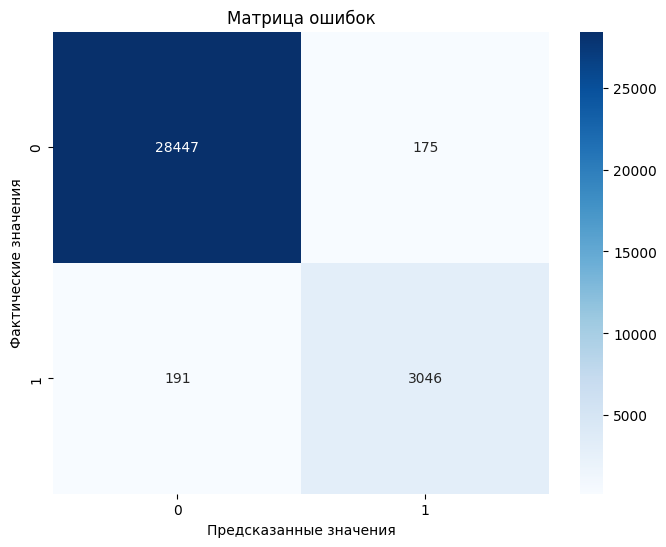

In [ ]:
cm = confusion_matrix(y_test, y_pred_tox)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения')
plt.show()

RoBERTa(toxic)

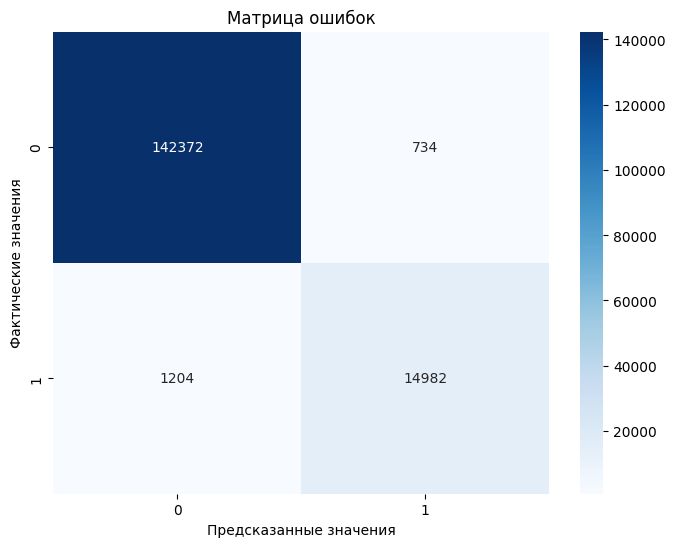

In [60]:
cm = confusion_matrix(y_test_full, binary_preds_new)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения')
plt.show()

Видим что модель ошиблась в крайне малом количестве предсказаний а именно 175 ошибочно признала текст токсичным и 191 пропустила действительно оскорбительный пост.

Модель RoBERTa(toxic) в целом обладает схожей предсказательной возможностью.

В целом разделение классов на достаточно высоком уровне.

### Вывод

- Мы протестировали большое количество моделей использовав разные подходы к кодированию изначальных текстов.

- Лучшие результаты показала , LogisticRegression на обработанном моделью RoBERTa(toxic) тексте, показав самый высокий результат по метрике f1 в 0.94.

- Предсказательная способность модели RoBERTa(toxic) так же на высоком уровне.

## Финальный вывод.

В качестве заказчика к нам обратилась компания «Викишоп» для разработки модели которая могла бы находить токсичные комментарии , была поставлена цель найти модель с точностью выше 0.75 по метрике F1. Вот чего нам удалось добиться.

- Мы загрузили присланный заказчиком датасет и при первичном ознакомлении явных дефектов в данных не обнаружено.

- Мы выполнили стандартную для такого случая обработку корпуса текстов , удалив из него не информативные артефакты выгрузки такие как : время , ip-адреса , и ссылки на сторонние ресурсы.

- Так же выполнили тонизацию и создали эмбидинги при помощи модели BERT.

- Первая итерация обучения моделей на эмбидингах BERT показала не удовлетворительные результаты достигнул всего лишь значения 0.7 по метрике f1.

- Мы использовали другой подход выполнил лемматизацию текстов и обработку TF-IDF , в этот раз требования заказчика удалось достигнуть обучив модель LinearSVC с значением метрики 0.78.

- В попытке улучшить результаты мы использовали модель RoBERTa(toxic) для разметки текстов а так же для предсказания. В этот раз удалось повысить качество моделей до 0.94.

### Рекомендации.

- Учитывая вычислительные ресурсы компании «Викишоп» , следует обратить внимание на модель RoBERTa(toxic) как средства разметки текстов для последующей передачи в LinearRegression или же полностью реализовать решение на этом классе моделей.


- Так же следует улучшить метод выгрузки данных , убрав из финального результата такие неинформативные данные как время , ip-адреса  , что повысило бы качество и скорость поиска неподходящих постов.